In [1]:
%config Completer.use_jedi = False
import tensorflow as tf
import numpy as np
import scipy as sp
import scipy.io
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
import csv
import random
import copy

from pyimagesearch.siamese_network import *
from pyimagesearch import config
from pyimagesearch import utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.callbacks import ModelCheckpoint

### Paths

In [2]:
ROOT_DIR = os.getcwd()
print(ROOT_DIR)

/home/alvaro/Vehicle-Model-Recognition


It should be /home/user/Vehicle-Model-Recognition

### Dataset parameters

In [3]:
total_classes = 10
elements_per_class = 30
training_split = 0.75
img_resolution = (224, 224)

### Training parameters

### Load images

In [4]:
os.chdir(ROOT_DIR + '/dataset')

In [5]:
car_names = os.listdir('./')
car_names.sort()

In [6]:
labels = random.sample(car_names, k = total_classes)
labels.sort()
print(labels)

['Audi TTS Coupe 2012', 'BMW M6 Convertible 2010', 'BMW X6 SUV 2012', 'Cadillac SRX SUV 2012', 'Chevrolet Camaro Convertible 2012', 'Chrysler PT Cruiser Convertible 2008', 'Daewoo Nubira Wagon 2002', 'GMC Canyon Extended Cab 2012', 'Isuzu Ascender SUV 2008', 'Nissan Juke Hatchback 2012']


In [7]:
(trainX, trainY), (testX, testY), (trainX_bbox, testX_bbox) = utils.load_dataset(ROOT_DIR, labels, elements_per_class, img_resolution=img_resolution, crop=True)
trainX = np.asarray(trainX)
trainY = np.asarray(trainY)
testX = np.asarray(testX)
testY = np.asarray(testY)
trainX.shape

(220, 224, 224, 3)

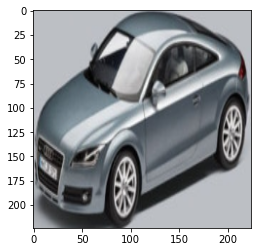

In [8]:
plt.imshow(trainX[0])

In [9]:
# add a channel dimension to the images
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
print(trainX.shape)
print(testX.shape)

(220, 224, 224, 3, 1)
(80, 224, 224, 3, 1)


In [10]:
norm_trainY = utils.normalize_labels(trainY)
norm_testY = utils.normalize_labels(testY)

In [11]:
# prepare the positive and negative pairs
print("[INFO] preparing positive and negative pairs...")
(pairTrain, labelTrain) = utils.make_pairs(trainX, norm_trainY)
(pairTest, labelTest) = utils.make_pairs(testX, norm_testY)

[INFO] preparing positive and negative pairs...


In [12]:
pairTrain.shape

(440, 2, 224, 224, 3, 1)

In [13]:
# configure the siamese network
print("[INFO] building siamese network...")
imgA = Input(shape=(img_resolution[0], img_resolution[1], 3))
imgB = Input(shape=(img_resolution[0], img_resolution[1], 3))
# featureExtractor = build_siamese_model((img_resolution[0], img_resolution[1], 1))
featureExtractor = build_vgg16((img_resolution[0], img_resolution[1], 3))
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

# finally, construct the siamese network
distance = Lambda(utils.euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

# compile the model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=["accuracy"])

[INFO] building siamese network...
[INFO] compiling model...


In [14]:
checkpoint_callback = ModelCheckpoint("saved_models/best_model.hdf5",
                                      monitor='val_accuracy',verbose=1,
                                      save_best_only=True, mode='auto',
                                      period=1)

In [15]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
VGG16_confA (Functional)        (None, 128)          129290752   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           VGG16_confA[0][0]     

In [16]:
# train the model
print("[INFO] training model...")
history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=4, 
	epochs=config.EPOCHS,
    callbacks=[checkpoint_callback])

[INFO] training model...
Epoch 1/100
110/110 [==============================] - ETA: 0s - loss: 36.3787 - accuracy: 0.4932
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to saved_models/best_model.hdf5
110/110 [==============================] - 235s 2s/step - loss: 36.3787 - accuracy: 0.4932 - val_loss: 18.9955 - val_accuracy: 0.5000
Epoch 2/100
110/110 [==============================] - ETA: 0s - loss: 14.4104 - accuracy: 0.4682
Epoch 00002: val_accuracy did not improve from 0.50000
110/110 [==============================] - 243s 2s/step - loss: 14.4104 - accuracy: 0.4682 - val_loss: 11.1785 - val_accuracy: 0.5000
Epoch 3/100
110/110 [==============================] - ETA: 0s - loss: 9.3882 - accuracy: 0.5000
Epoch 00003: val_accuracy did not improve from 0.50000
110/110 [==============================] - 240s 2s/step - loss: 9.3882 - accuracy: 0.5000 - val_loss: 7.9287 - val_accuracy: 0.5000
Epoch 4/100
110/110 [==============================] - ETA: 0s - loss:

KeyboardInterrupt: 